In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


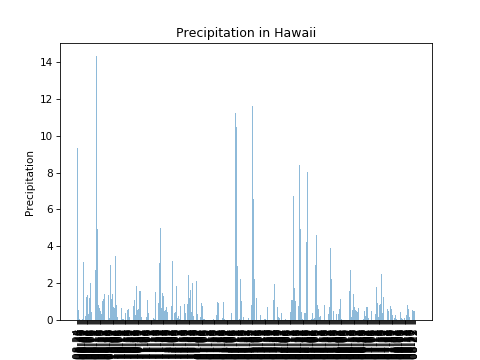

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from August 23, 2017
one_year = timedelta(days=365)
d = dt.datetime(2017, 8, 23)
# Perform a query to retrieve the data and precipitation scores
one_yearprcp = session.query(Measurement.date,Measurement.prcp)\
                            .filter(Measurement.date > (d-one_year)).all()
one_yearprcp
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(one_yearprcp).groupby(['date']).sum()
# Sort the dataframe by date
prcp_df.sort_values(by=['date'])
prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
plt.rcdefaults()
x_axis = np.arange(len(prcp_df))
y_axis = prcp_df['prcp']
xticks = prcp_df.index

plt.bar(x_axis, y_axis, align='center', alpha=0.5)
plt.xticks(x_axis,xticks,rotation=90)

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation in Hawaii')
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sum = prcp_df.describe()
prcp_sum

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [12]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station))
s_count = stations[0]
s_count

(9)

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
act_count = session.query(Measurement.station, func.count(Measurement.prcp))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.prcp).desc())


for station in act_count:
    print(station)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
most_active = act_count[0][0]

tobs_results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
               .filter(Measurement.station == most_active)
        

# Converting to a list
tobs_data = []
for row in tobs_results:
    print("Min temp: ",row[0])
    print("Max temp: ",row[1])
    print("Avg temp: ",row[2])
    tobs_data.append(row)

Min temp:  54.0
Max temp:  85.0
Avg temp:  71.66378066378067
USC00519281


In [17]:
# Choose the station with the highest number of temperature observations.
t_stationcount = session.query(Measurement.station, func.count(Measurement.tobs))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.tobs).desc()).first()

print(t_stationcount)

for station in t_stationcount:
    print(station)

('USC00519281', 2772)
USC00519281
2772


<IPython.core.display.Javascript object>


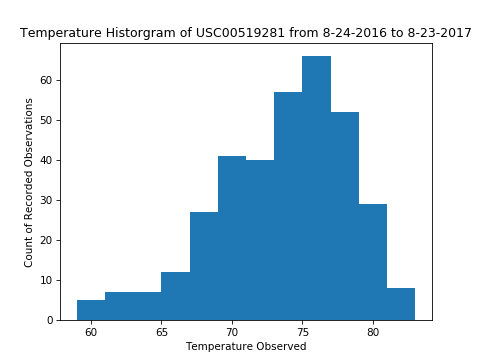

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Most active station for precipitation is also most active station for temperature observed, so most_active is the same
one_yeartobs = session.query(Measurement.station,Measurement.date,Measurement.tobs)\
                            .filter(Measurement.station == most_active)\
                            .filter(Measurement.date > (d-one_year)).all()
tobs_df = pd.DataFrame(one_yeartobs)
plt.hist(tobs_df['tobs'], 12)
plt.xlabel("Temperature Observed")
plt.ylabel("Count of Recorded Observations")
plt.title("Temperature Historgram of " + most_active + " from 8-24-2016 to 8-23-2017")
plt.show()

In [29]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
planned_arrival = dt.date(2018,7,19)
planned_leave = dt.date(2018,7,23)
#one_year
lastyear_temp = (calc_temps((planned_arrival-one_year),(planned_leave-one_year)))
print(lastyear_temp)

[(72.0, 78.35483870967742, 82.0)]


<IPython.core.display.Javascript object>


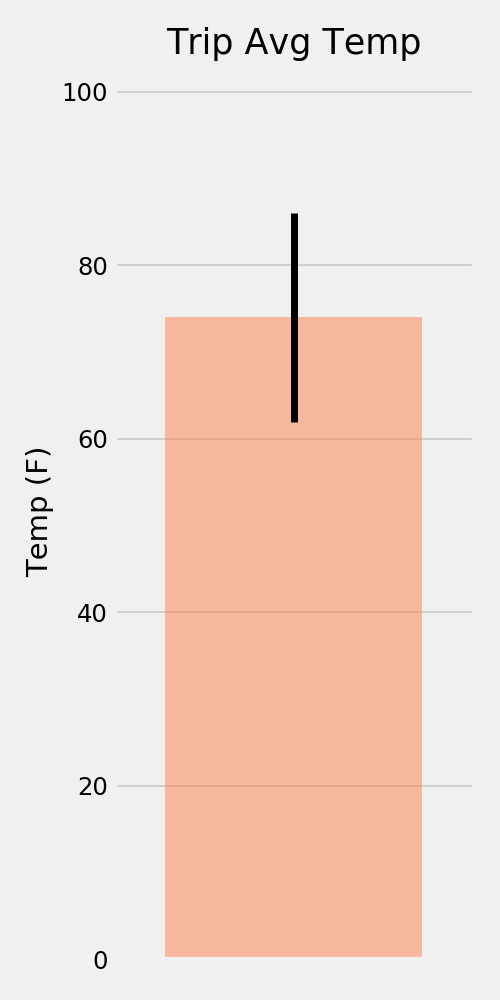

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x_axis, lastyear_temp, align='center', alpha=0.5, yerr=lastyear_temp[0][2]-lastyear_temp=)
plt.xticks(x_axis,xticks,rotation=90)

plt.ylabel('Avg Temperature')
plt.title('Trip Avg Temp')
plt.savefig("Images/temp_analysis.png")
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


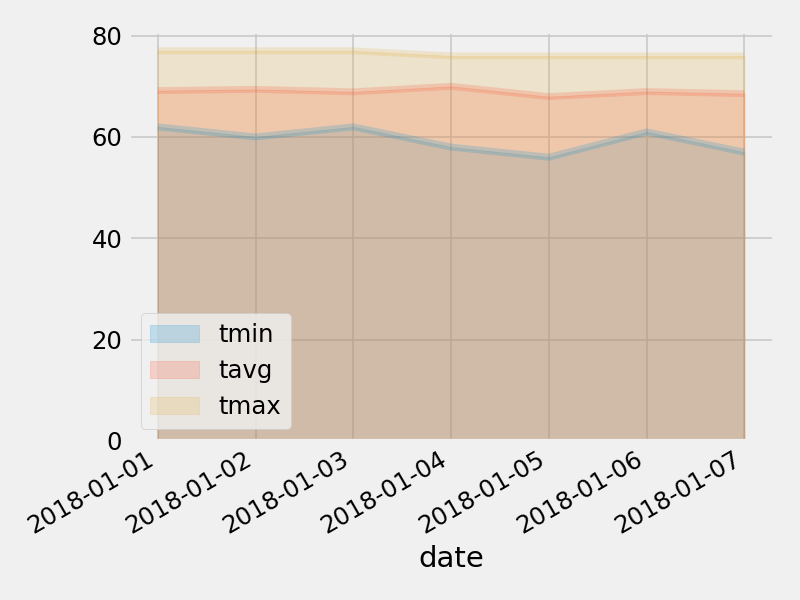

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
